In [1]:
import numpy as np, prjlib, plottools as pl, healpy as hp, pickle, curvedsky, tools_delens, misctools, tools_lens, tools_delens
# widget packages
import ipywidgets as widgets
%matplotlib inline
from matplotlib.pyplot import *

In [2]:
def viewmaps(klms,nside=128,lmax=256,min=-0.1,max=0.1,M=1.):

    qlist = list(klms.keys())
    print(qlist)
    
    N = len(qlist)
    out = []
    for n in range(N):
        out.append(widgets.Output())

    tab = widgets.Tab(children = out)
    for n in range(N):
        tab.set_title(n,qlist[n])

    display(tab)

    fig, ax = {}, {}
    for qi, q in enumerate(qlist):
        kap = M * curvedsky.utils.hp_alm2map(nside,lmax,lmax,klms[q][:lmax+1,:lmax+1])

        with out[qi]:
            fig[q], ax[q] = subplots(figsize=[10,7])
            sca(ax[q])
            hp.mollview(kap,min=min,max=max,hold=True)
            show(fig[q])

In [3]:
p = prjlib.analysis_init(t='la',freq='com',fltr='cinv',snmin=1,snmax=100,ntype='base_roll50')
P = prjlib.analysis_init(t='la',freq='com',fltr='none',snmin=1,snmax=100,ntype='base_roll50')
qobj = tools_lens.init_qobj(p.stag,False,rlmin=300,rlmax=4096,qlist=['TT','TE','EE','EB'])
Qobj = tools_lens.init_qobj(P.stag,False,rlmin=300,rlmax=4096,qlist=['TT','TE','EE','EB'])
i = 1
Lmax = 2048
nside, npix, lmax = 128, 12*128**2, 2*128

In [4]:
W, wn = prjlib.window('la',ascale=5.0)
M = W/(W+1e-30)
iW2 = hp.ud_grade(M/(W+1e-30)**2,nside)
M = hp.ud_grade(M,nside)
wn = prjlib.wfac('la')

In [19]:
ikalm = prjlib.load_input_plm(p.fpalm[i],lmax,ktype='k')
ikwlm = curvedsky.utils.mulwin(p.nside,lmax,lmax,ikalm,W**2)

In [15]:
wlk = tools_delens.diag_wiener(qobj.f,p.kk,20,Lmax,klist=qobj.qlist)
rkwlm = {}
rkalm = {}
for q in ['TT','TE','EE','EB']:
    rkalm[q] = pickle.load(open(qobj.f[q].alm[i],"rb"))[0][:lmax+1,:lmax+1]
    mlm = pickle.load(open(qobj.f[q].mfb[i],"rb"))[0][:lmax+1,:lmax+1]
    rkalm[q] -= mlm
    rkwlm[q] = rkalm[q]*wlk[q][:lmax+1,None]

load diag wiener filter:: 100%|███████████████████████████████████████| 4/4 [00:00<00:00, 37.29it/s]


In [24]:
wlK = tools_delens.diag_wiener(Qobj.f,p.kk,20,Lmax,klist=Qobj.qlist)
rKwlm = {}
rKalm = {}
for q in ['TT','TE','EE','EB']:
    rKalm[q] = pickle.load(open(Qobj.f[q].alm[i],"rb"))[0][:lmax+1,:lmax+1]
    mlm = pickle.load(open(Qobj.f[q].mfb[i],"rb"))[0][:lmax+1,:lmax+1]
    rKalm[q] -= mlm
    rKwlm[q] = rKalm[q]*wlK[q][:lmax+1,None]

load diag wiener filter:: 100%|███████████████████████████████████████| 4/4 [00:00<00:00, 37.29it/s]


In [13]:
wkwlm = pickle.load(open(qobj.f['TT'].walm[i],"rb"))[0][:lmax+1,:lmax+1]

In [27]:
# cinv case
klms = {}
klms['IN'] = ikalm
klms['TT'] = rkwlm['TT']/wn[0]
klms['TE'] = rkwlm['TE']/wn[0]
klms['EE'] = rkwlm['EE']/wn[0]
klms['EB'] = rkwlm['EB']/wn[0]
klms['TTw'] = wkwlm
viewmaps(klms,M=M)

['IN', 'TT', 'TE', 'EE', 'EB', 'TTw']


In [29]:
# simple quadratic reconstruction from apodized map
klms = {}
klms['INw'] = ikwlm/wn[2]
klms['TT'] = rKwlm['TT']/wn[2]
klms['TE'] = rKwlm['TE']/wn[2]
klms['EE'] = rKwlm['EE']/wn[2]
klms['EB'] = rKwlm['EB']/wn[2]
viewmaps(klms,M=iW2)

['INw', 'TT', 'TE', 'EE', 'EB']


In [30]:
klms = {}
klms['INw'] = ikalm
klms['TT'] = rkalm['TT']
klms['EB'] = rkalm['EB']
klms['TTN'] = rkalm['TT'] - ikalm
klms['EBN'] = rkalm['EB'] - ikalm
viewmaps(klms,M=M,min=-0.05,max=0.05)

['INw', 'TT', 'EB', 'TTN', 'EBN']


In [25]:
klms = {}
klms['INw'] = ikwlm
klms['TT'] = rKalm['TT']
klms['EB'] = rKalm['EB']
klms['TTN'] = rKalm['TT'] - ikwlm
klms['EBN'] = rKalm['EB'] - ikwlm
viewmaps(klms,M=iW2,min=-0.05,max=0.05)

['INw', 'TT', 'EB', 'TTN', 'EBN']


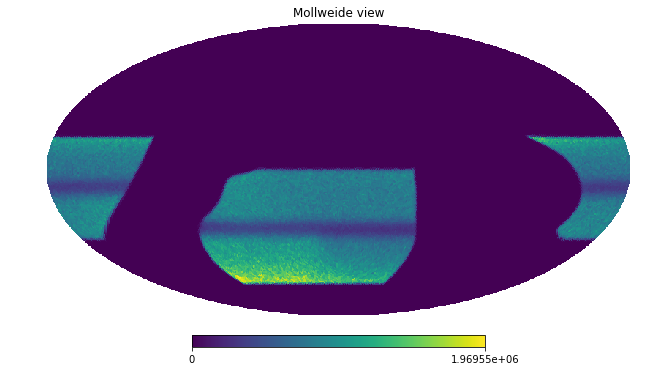

In [55]:
inkk = hp.ud_grade(hp.ud_grade(pickle.load(open(Qobj.f['EE'].nkmap,"rb")),64),2048)
hp.mollview(inkk)

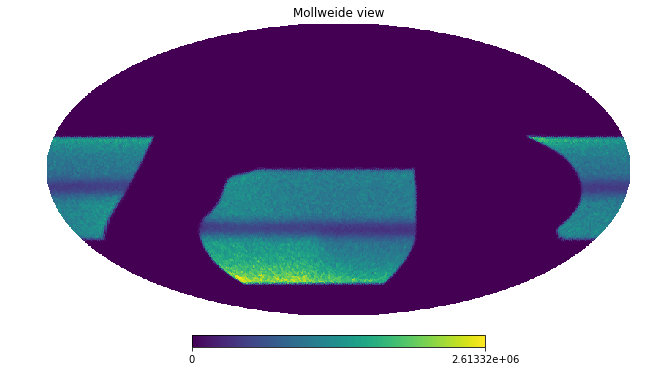

In [58]:
Al = np.loadtxt(Qobj.f['EE'].al,unpack=True)[1]
iNkk = np.mean(1./Al[2:1000]) * inkk/np.max(inkk)
hp.mollview(iNkk)